# PCMLIA Capstone: Detection of Simulated Attacks on a Gas Pipeline

## Context and objective

Cyberattacks are a major issue in the industrial sector. As the number of connected systems and devices, so do the costs of cybercrime and malware. An attack on critical infrastructure could lead to serious consequences. However, artificial intelligence can be leveraged to analyze data and alert users of anomalies in real time. The ability to automatically detect and mitigate threats makes AI an invaluable tool in the modern world.

This captone project examines data from an industrial control system for a gas pipeline as described in the paper "[Industrial Control System Network Traffic Data sets to Facilitate Intrusion Detection System Research](https://link.springer.com/chapter/10.1007/978-3-662-45355-1_5)" by Tommy Morris and Wei Gao. It aims to create a model to detect and classify simulated attacks, as well as provide insights on how artificial intelligence could be used to mitigate cyber threats in our increasingly connected world.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import lightgbm as lgb

from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.tree import *

from joblib import dump, load

In [2]:
# set up environment and connect to Google Drive
import os

from google.colab import drive

drive_root = '/content/drive'
if not os.path.exists(drive_root):
  drive.mount(drive_root)

colab_home = f'{drive_root}/MyDrive/Colab'
ws = f'{colab_home}/workspace_ucb_ml'

os.chdir(ws)

Mounted at /content/drive


## Data understanding

The data set was obtained from the [Industrial Control System (ICS) Cyber Attack Datasets](https://sites.google.com/a/uah.edu/tommy-morris-uah/ics-data-sets) website \([direct link](http://ece.uah.edu/~thm0009/icsdatasets/gas_final.arff)\) run by Tommy Morris. The data was converted from ARFF to CSV using an [online tool](https://pulipulichen.github.io/jieba-js/weka/arff2csv) developed by Pulipuli Chen.

In [3]:
gas = pd.read_csv('data/capstone/gas_final.csv')

In [4]:
# remove quote marks from column names
gas.rename(lambda c: c.strip('\''), axis='columns', inplace=True)

In [5]:
# show all columns in data
pd.set_option('display.max_columns', None)

# verify data is loaded correctly
gas.head()

,id,command_address,response_address,command_memory,response_memory,command_memory_count,response_memory_count,comm_read_function,comm_write_fun,resp_read_fun,resp_write_fun,sub_function,command_length,resp_length,gain,reset,deadband,cycletime,rate,setpoint,control_mode,control_scheme,pump,solenoid,crc_rate,measurement,time,result
0,1,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.528736,1.106868,0
1,2,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.540230,1.043098,0
2,3,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.540230,1.266332,0
3,4,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.540230,1.116280,0
4,5,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.528736,1.257916,0


### Exploratory data analysis

The data set contains the following 27 features:

* Attributes of command-response pair
  * `command_address` - device ID in command packet
  * `response_address` - device ID in reponse packet
  * `command_memory` - memory address in command packet
  * `response_memory` - memory address in reponse packet
  * `command_memory_count` - bytes in memory for read and write command
  * `response_memory_count` - bytes in memory for read and write response
  * `command_length` - length of command packet
  * `resp_length` - length of response packet
  * `time` - elapsed time between command and response
  * `crc_rate` - CRC error rate
* Packet payload attributes
  * `comm_read_function` - value of read command function code
  * `comm_write_fun` - value of write command function code
  * `resp_read_fun` - value of read response function code
  * `resp_write_fun` - value of read response function code
  * `sub_function` - value of sub-function code
  * `measurement` - pipeline pressure
  * `control_mode` - categorical variable indicating the system's control mode (0 = shutdown, 1 = manual, 2 = automatic)
  * `pump` - categorical variable indicating the pipeline's compressor state (0 = inactive, 1 = active)
* Gas pipeline attributes
  * `setpoint` - configured gas pipeline pressure
  * `control_scheme` - gas pipeline control scheme
  * `solenoid` - state of the solenoid used to control the pressure relief valve (0 = inactive, 1 = active)
  * `gain` - value of gain parameter in PID controller
  * `reset` - value of reset parameter in PID controller
  * `deadband` - value of dead gain parameter in PID controller
  * `rate` - value of rate parameter in PID controller
  * `cycletime` - value of cycle time parameter in PID controller
* Target variable
  * `result` - manual classification of the attack type (0 = not an attack)

The `id` column was automatically created during the ARFF to CSV conversion process. Because each item under `id` has a unique value, this is a non-informative feature that will be removed during the data cleaning step. Furthermore, some features in the data set did not match those described in the paper. The features that were mentioned in the paper but absent from the data set are not listed here.

In [6]:
# drop the non-informative "id" column
gas.drop('id', axis=1, inplace=True)

In [7]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97019 entries, 0 to 97018
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   command_address        97019 non-null  int64  
 1   response_address       97019 non-null  int64  
 2   command_memory         97019 non-null  int64  
 3   response_memory        97019 non-null  int64  
 4   command_memory_count   97019 non-null  int64  
 5   response_memory_count  97019 non-null  int64  
 6   comm_read_function     97019 non-null  int64  
 7   comm_write_fun         97019 non-null  int64  
 8   resp_read_fun          97019 non-null  int64  
 9   resp_write_fun         97019 non-null  int64  
 10  sub_function           97019 non-null  int64  
 11  command_length         97019 non-null  int64  
 12  resp_length            97019 non-null  int64  
 13  gain                   97019 non-null  int64  
 14  reset                  97019 non-null  float64
 15  de

In [ ]:
gas.describe()

,command_address,response_address,command_memory,response_memory,command_memory_count,response_memory_count,comm_read_function,comm_write_fun,resp_read_fun,resp_write_fun,sub_function,command_length,resp_length,gain,reset,deadband,cycletime,rate,setpoint,control_mode,control_scheme,pump,solenoid,crc_rate,measurement,time,result
count,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.0,97019.000000,97019.000000,97019.000000,97019.0,97019.000000,97019.0,9.701900e+04,97019.0,97019.0,97019.0,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.0,9.701900e+04,97019.000000,97019.000000
mean,4.585226,3.719436,182.918099,216.657170,8.990012,16.737464,3.045878,10.0,2.449963,9.298591,0.016017,41.0,26.294654,115.0,2.000000e-01,0.5,1.0,0.0,24.166607,0.899659,0.992146,0.056381,0.027366,0.0,-2.772582e+34,1.139626,1.320473
std,8.951157,1.021543,3.674067,59.504855,0.282658,4.596942,0.724514,0.0,0.893052,2.553856,0.239158,0.0,26.560107,0.0,2.775572e-17,0.0,0.0,0.0,14.322356,0.991003,0.088275,0.230657,0.163148,0.0,1.818736e+36,0.091356,2.126200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0,1.000000,0.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.515320e+38,1.000000,0.000000
25%,4.000000,4.000000,183.000000,233.000000,9.000000,18.000000,3.000000,10.0,1.000000,10.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.183908e-01,1.057822,0.000000
50%,4.000000,4.000000,183.000000,233.000000,9.000000,18.000000,3.000000,10.0,3.000000,10.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,0.000000,1.000000,0.000000,0.000000,0.0,3.218391e-01,1.138303,0.000000
75%,4.000000,4.000000,183.000000,233.000000,9.000000,18.000000,3.000000,10.0,3.000000,10.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,2.000000,1.000000,0.000000,0.000000,0.0,5.258621e+00,1.219292,2.000000
max,249.000000,4.000000,255.000000,233.000000,9.000000,18.000000,19.000000,10.0,3.000000,10.000000,4.000000,41.0,123.000000,115.0,2.000000e-01,0.5,1.0,0.0,90.000000,2.000000,1.000000,1.000000,1.000000,0.0,2.299564e+38,1.299998,7.000000


In [ ]:
# get the median for measurement for later use
median_meas_static = gas['measurement'].median()

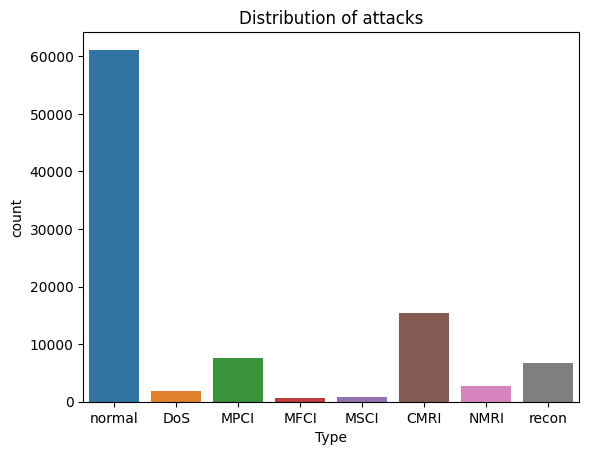

In [10]:
# visualize attack types
attacks = {
    0: 'normal',
    1: 'NMRI',
    2: 'CMRI',
    3: 'MSCI',
    4: 'MPCI',
    5: 'MFCI',
    6: 'DoS',
    7: 'recon'
}

sns.countplot(data=gas.assign(result=gas['result'].map(attacks)), x='result', hue='result')
plt.title('Distribution of attacks')
plt.xlabel('Type')
plt.show()

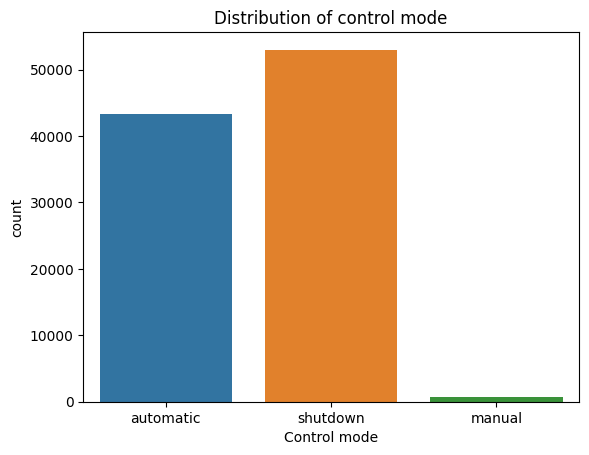

In [12]:
# visualize control mode
control_modes = {
    0: 'shutdown',
    1: 'manual',
    2: 'automatic'
}

sns.countplot(data=gas.assign(control_mode=gas['control_mode'].map(control_modes)), x='control_mode', hue='control_mode')
plt.title('Distribution of control mode')
plt.xlabel('Control mode')
plt.show()

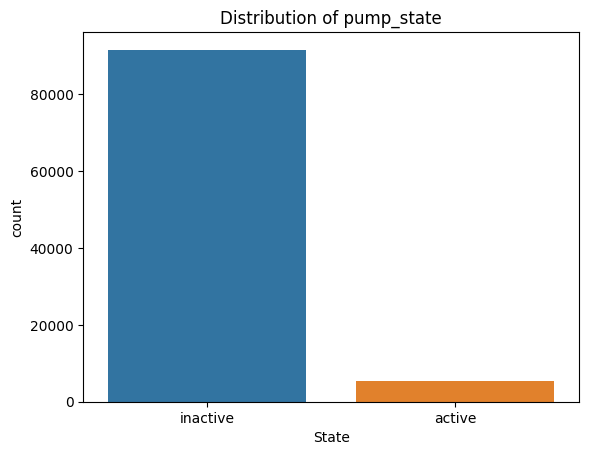

In [15]:
# visualize pump state
pump_states = {
    0: 'inactive',
    1: 'active'
}

sns.countplot(data=gas.assign(pump=gas['pump'].map(pump_states)), x='pump', hue='pump')
plt.title('Distribution of pump_state')
plt.xlabel('State')
plt.show()

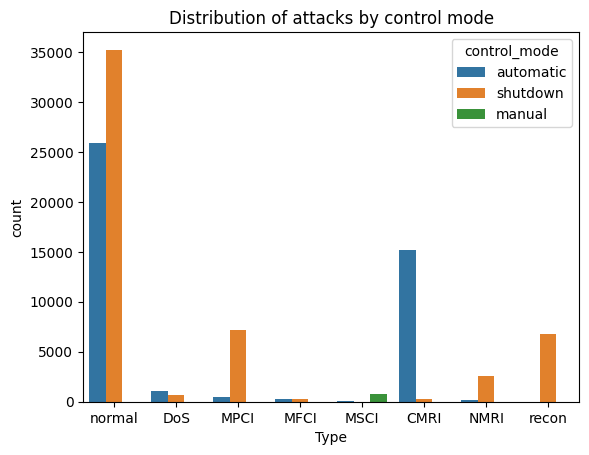

In [19]:
sns.countplot(data=gas.assign(result=gas['result'].map(attacks), control_mode=gas['control_mode'].map(control_modes)), x='result', hue='control_mode')
plt.title('Distribution of attacks by control mode')
plt.xlabel('Type')
plt.show()

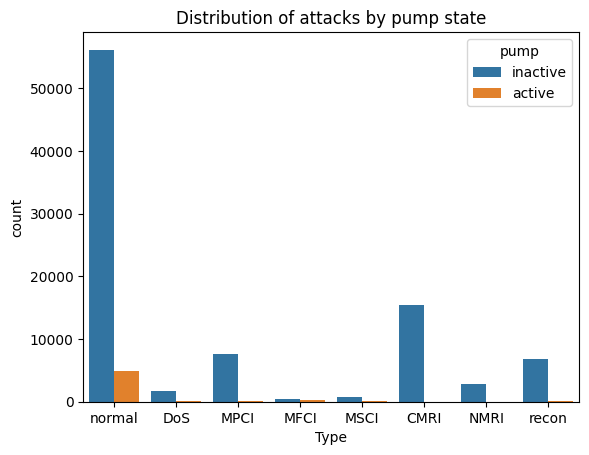

In [22]:
sns.countplot(data=gas.assign(result=gas['result'].map(attacks), pump=gas['pump'].map(pump_states)), x='result', hue='pump')
plt.title('Distribution of attacks by pump state')
plt.xlabel('Type')
plt.show()

### Observations

* The data has no missing values
* About a third of all packets are part of an attack
* A number of columns have only one unique value; these are removed as part of the data cleaning process
* The `measurement` column contains some obviously incorrect values; these are adjusted during the data pre-processing

## Data preparation

In [ ]:
# we want only columns with more than one unique value
unique_cols = gas.min() != gas.max()
gas_clean = gas.copy()[gas.columns[gas.min() != gas.max()]]

In [ ]:
gas_clean.head()

,command_address,response_address,command_memory,response_memory,command_memory_count,response_memory_count,comm_read_function,resp_read_fun,resp_write_fun,sub_function,resp_length,setpoint,control_mode,control_scheme,pump,solenoid,measurement,time,result,adjusted_measurement
0,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.528736,1.106868,0,0.528736
1,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.540230,1.043098,0,0.540230
2,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.540230,1.266332,0,0.540230
3,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.540230,1.116280,0,0.540230
4,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.528736,1.257916,0,0.528736


It can be seen that the `measurement` column contains extreme values. Determining the cutoff point may be difficult because the source paper makes no mention of units used. However, the `setpoint` column has a maximum value of 90. It is therefore reasonable to assume that the pressures in the pipeline must be in the same order of magnitude. In this particular case, we replace values above 1,000 with the median.

In [ ]:
lower_meas_limit = 0
upper_meas_limit = 1000
gas_clean['adjusted_measurement'] = gas['measurement']

bad_meas_idx = gas_clean[gas_clean['measurement'] > upper_meas_limit].index
bad_meas_idx = bad_meas_idx.union(gas_clean[gas_clean['measurement'] < lower_meas_limit].index)
gas_clean.loc[bad_meas_idx, 'adjusted_measurement'] = median_meas_static

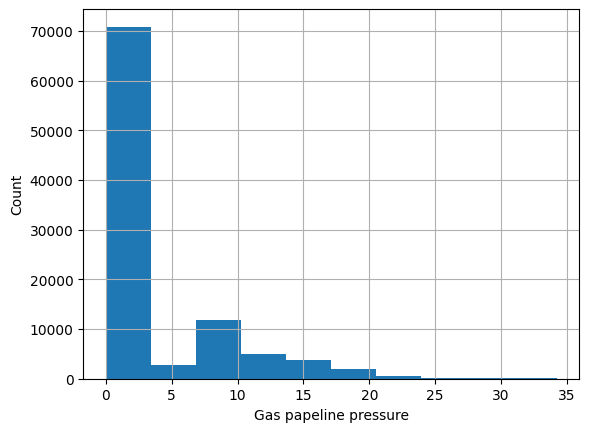

In [ ]:
gas_clean['adjusted_measurement'].hist()
plt.xlabel('Gas papeline pressure')
plt.ylabel('Count')
plt.show()

## Modeling

In [ ]:
X = gas_clean.drop('result', axis=1)
y = gas_clean['result']

columns = X.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# create a function to visualize feature importance for models that support it
def feature_importance(model, features=columns):
  importances = model.feature_importances_

  importance_df = pd.DataFrame(importances, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
  plt.figure()
  sns.barplot(x=importance_df.Importance, y=importance_df.index)
  plt.show()

### Decision trees

In [ ]:
%%time
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

CPU times: user 549 ms, sys: 12 ms, total: 561 ms
Wall time: 577 ms


DecisionTreeClassifier(random_state=1)

In [ ]:
# classify the test data using the trained model
y_pred_dt = dt.predict(X_test)

Baseline decision tree accuracy: 0.9878375592661307


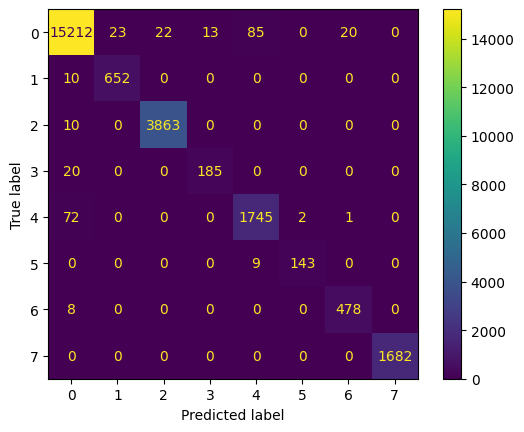

In [ ]:
print("Baseline decision tree accuracy:", accuracy_score(y_test, y_pred_dt))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.show()

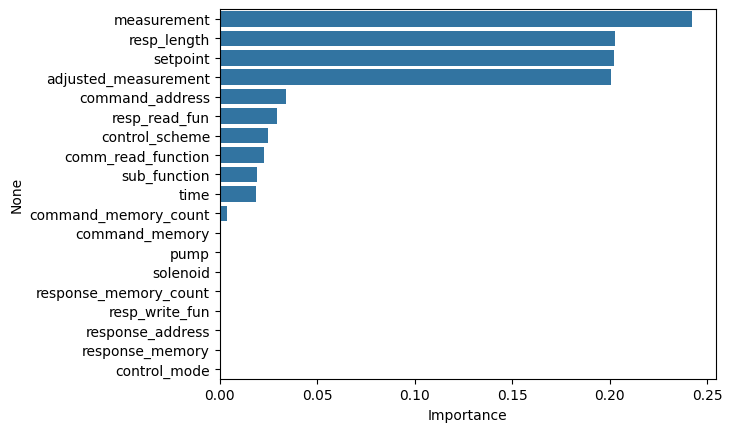

In [ ]:
feature_importance(dt)

We create a second instance that ignores the less-important features.

In [ ]:
dt_exclude_columns = [
    'command_memory',
    'pump',
    'solenoid',
    'response_memory_count',
    'resp_write_fun',
    'response_address',
    'response_memory',
    'control_mode'
]

In [ ]:
X_train_dt_ss = X_train.drop(columns=dt_exclude_columns, axis=1)
X_test_dt_ss = X_test.drop(columns=dt_exclude_columns, axis=1)

In [ ]:
%%time
dt_ss = DecisionTreeClassifier(random_state=1)
dt_ss.fit(X_train_dt_ss, y_train)

CPU times: user 599 ms, sys: 9.62 ms, total: 609 ms
Wall time: 1.42 s


DecisionTreeClassifier(random_state=1)

In [ ]:
# classify the test data using the trained model
y_pred_dt_ss = dt_ss.predict(X_test_dt_ss)

Decision tree accuracy excluding low-importance features: 0.9875489589775304


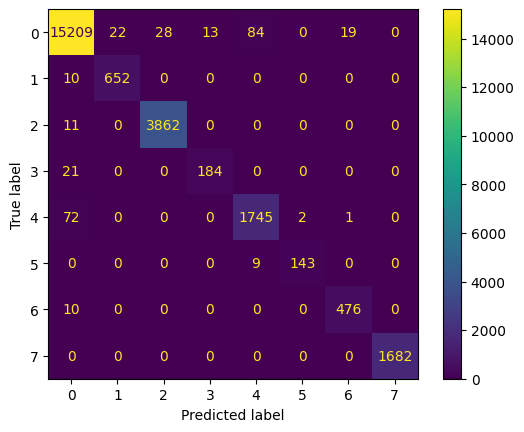

In [ ]:
print("Decision tree accuracy excluding low-importance features:", accuracy_score(y_test, y_pred_dt_ss))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(dt_ss, X_test_dt_ss, y_test)
plt.show()

### Random forests

In [ ]:
%%time
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

CPU times: user 10.3 s, sys: 13.7 ms, total: 10.3 s
Wall time: 13.9 s


RandomForestClassifier(random_state=1)

In [ ]:
# classify the test data using the trained model
y_pred_rf = rf.predict(X_test)

Baseline random forest accuracy: 0.9890744176458462


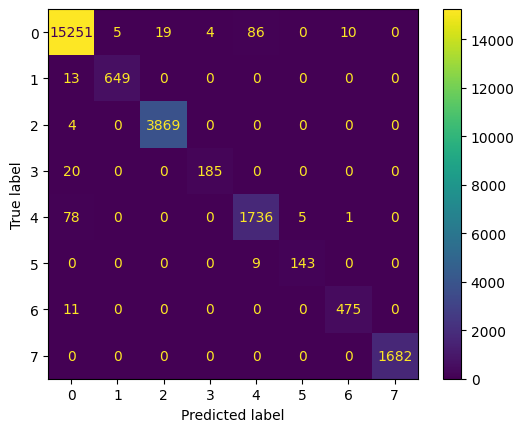

In [ ]:
print("Baseline random forest accuracy:", accuracy_score(y_test, y_pred_rf))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.show()

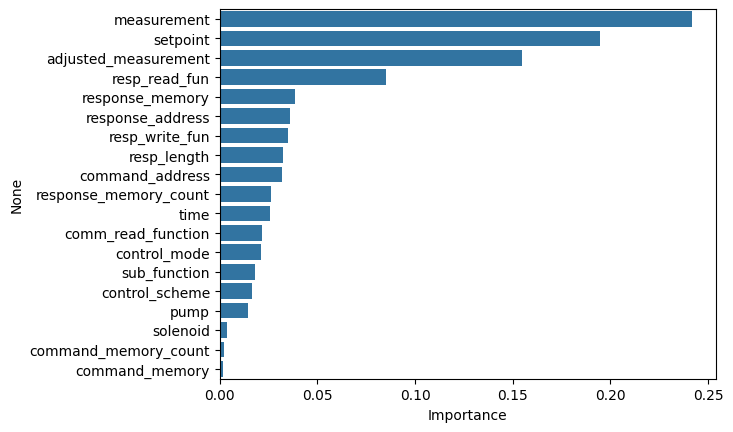

In [ ]:
feature_importance(rf)

We create a second instance that ignores the less-important features.

In [ ]:
rf_exclude_columns = [
    'solenoid',
    'command_memory',
    'response_memory_count'
]

In [ ]:
X_train_rf_ss = X_train.drop(columns=rf_exclude_columns, axis=1)
X_test_rf_ss = X_test.drop(columns=rf_exclude_columns, axis=1)

In [ ]:
%%time
rf_ss = RandomForestClassifier(random_state=1)
rf_ss.fit(X_train_rf_ss, y_train)

CPU times: user 10.7 s, sys: 39.4 ms, total: 10.7 s
Wall time: 11.6 s


RandomForestClassifier(random_state=1)

In [ ]:
# classify the test data using the trained model
y_pred_rf_ss = rf_ss.predict(X_test_rf_ss)

Random forest accuracy excluding low-importance features: 0.9889919604205318


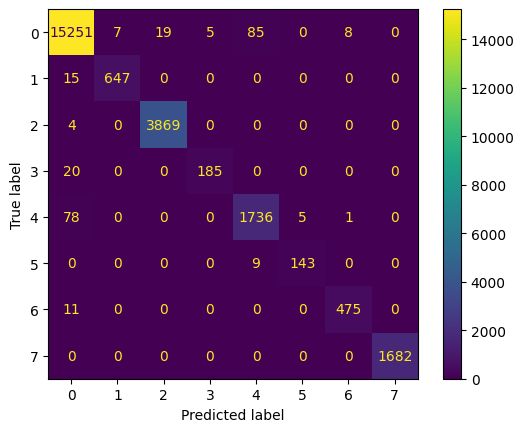

In [ ]:
print("Random forest accuracy excluding low-importance features:", accuracy_score(y_test, y_pred_rf_ss))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_ss, X_test_rf_ss, y_test)
plt.show()

### Gradient boosting classifier

In [ ]:
%%time
gbc = HistGradientBoostingClassifier(random_state=1)
gbc.fit(X_train, y_train)

CPU times: user 7.46 s, sys: 59.1 ms, total: 7.52 s
Wall time: 9.06 s


HistGradientBoostingClassifier(random_state=1)

In [ ]:
# classify the test data using the trained model
y_pred_gbc = gbc.predict(X_test)

Baseline gradient-boosting classifier Accuracy: 0.9911770768913626


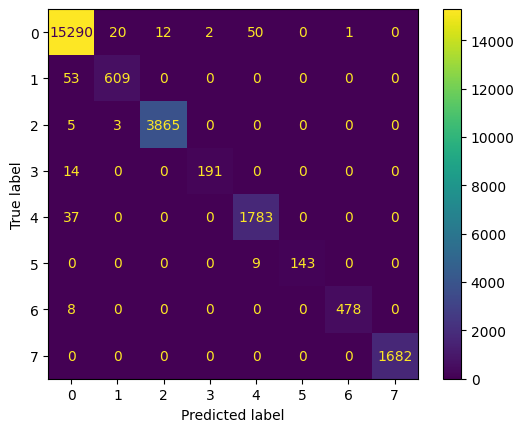

In [ ]:
print("Baseline gradient-boosting classifier Accuracy:", accuracy_score(y_test, y_pred_gbc))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test)
plt.show()

### Light GBM

In [ ]:
%%time
lgbm = lgb.LGBMClassifier(force_row_wise=True)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 72764, number of used features: 19
[LightGBM] [Info] Start training from score -0.463352
[LightGBM] [Info] Start training from score -3.544808
[LightGBM] [Info] Start training from score -1.836820
[LightGBM] [Info] Start training from score -4.837134
[LightGBM] [Info] Start training from score -2.526437
[LightGBM] [Info] Start training from score -5.152344
[LightGBM] [Info] Start training from score -3.986376
[LightGBM] [Info] Start training from score -2.653481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 6.15 s, sys: 55.4 ms, total: 6.2 s
Wall time: 6.78 s


LGBMClassifier(force_row_wise=True)

In [ ]:
y_pred_lgbm = lgbm.predict(X_test)

Baseline Light GBM accuracy: 0.9900226757369615


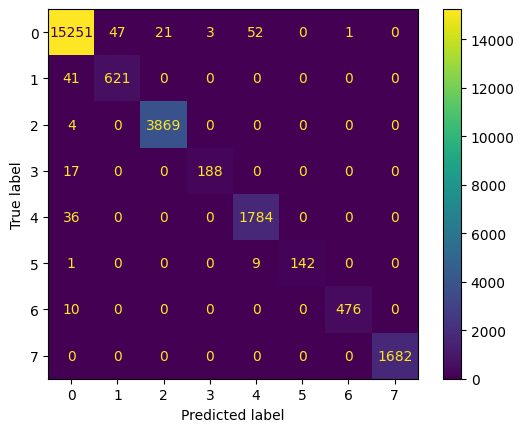

In [ ]:
print("Baseline Light GBM accuracy:", accuracy_score(y_test, y_pred_lgbm))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test)
plt.show()

### Observations

* All four models gave very high predictive performance. Out of those four models, the histogram-based gradient-boosting machine had the highest accuracy
* For the decision tree and random forest classifiers, dropping low-importance features resulted in a very slight drop in accuracy but did not significantly affect the time needed to train the models
* Light GBM has the second-best accuracy but the shortest training time

## Evaluation

We now evaluate and further improve the optimal classifier, the histogram-based gradient boosting machine in this case. In a real-world scenario, the objective should be to detect as many attacks as possible; this would require us to optimize the recall or F<sub>1</sub> score. However, because this particular data set is fairly balanced if the data is split into attacks and non-attacks, we will use the accuracy score for this exercuse.

In [ ]:
gbc_params = {
    'max_iter': [100, 500, 1000],
    'learning_rate': [0.1, 0.5],
    'max_depth': [25, 50]
}

gbc_grid_saved = 'gbc_optimal.joblib'
gbc_grid_path = f'data/capstone/saved_models/{gbc_grid_saved}'

if os.path.isfile(gbc_grid_path):
  print(f'Found existing saved model: {gbc_grid_saved}')
  gbc_grid = load(gbc_grid_path)
else:
  gbc_grid = GridSearchCV(gbc, param_grid=gbc_params, cv=5)
  gbc_grid.fit(X_train, y_train)
  dump(gbc_grid, gbc_grid_path)

gbc_grid

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=1),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [25, 50],
                         'max_iter': [100, 500, 1000]})

In [ ]:
# classify the test data using the trained model
y_pred_gbc_optimal = gbc_grid.predict(X_test)

Accuracy: 0.9911770768913626


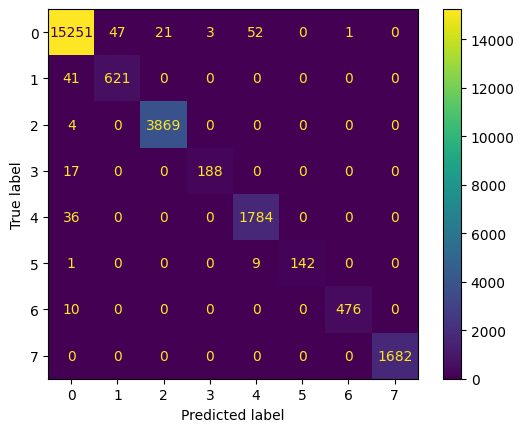

In [ ]:
print("Accuracy of optimal gradient-boosting model:", accuracy_score(y_test, y_pred_gbc_optimal))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test)
plt.show()